# Stacking

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

import argparse
import wandb
wandb.init(project="DACON_235942", name="stacking")

parser = argparse.ArgumentParser(description="stacking")
parser.add_argument('--top_n_model', default=3, type=int)
parser.add_argument('--scaler', default="standard", type=str) # standard or minmax
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

top_n_model = args.top_n_model
scaler = args.scaler
cv = args.cv
seed = args.seed

if scaler == "standard":
    scaler=StandardScaler()
elif scaler == "minmax":
    scaler=MinMaxScaler()

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


## Preprocessing

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


### Weekly_Sales

In [4]:
# for i in train["Store"].unique():
#     temp = train[train["Store"]==i]
#     plt.figure(figsize=(15,8))
#     sns.lineplot(x="Date", y="Weekly_Sales", data=temp)
#     plt.title(f"Store : {i}")
#     plt.xticks('off')
#     plt.show()

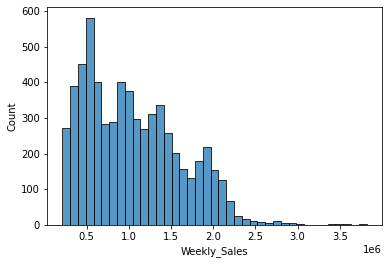

In [5]:
sns.histplot(train["Weekly_Sales"])
plt.show()

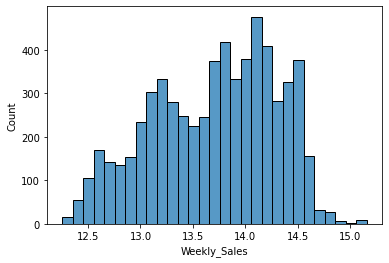

In [6]:
train["Weekly_Sales"] = np.log(train["Weekly_Sales"])
sns.histplot(train["Weekly_Sales"])
plt.show()

### Store

In [7]:
train["Store"] = train["Store"].astype("object")
test["Store"] = test["Store"].astype("object")

train["Store"].nunique(), test["Store"].nunique()

(45, 45)

### Date

In [8]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,14.312455
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,14.311400
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,14.292966
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,14.158907
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,14.256862


In [9]:
def seperate_datetime(df):
    year = []
    month = []
    day = []
    for date in df:
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

train_year, train_month, train_day = seperate_datetime(train["Date"].astype("str"))
test_year, test_month, test_day = seperate_datetime(test["Date"].astype("str"))
    
train['year'] = train_year
train['month'] = train_month
train['day'] = train_day

test['year'] = test_year
test['month'] = test_month
test['day'] = test_day

train["week"] = train["Date"].dt.week
test["week"] = test["Date"].dt.week

def seasonal(x):
    if (x >= 3) & (x <= 5):
        x = 1
    elif (x >= 6) & (x <= 8):
        x = 2
    elif (x >= 9) & (x <= 11):
        x = 3
    elif (x >= 12) | (x <= 2):
        x = 4
    return x

train["season"] = train["month"].apply(lambda x : seasonal(x))
test["season"] = test["month"].apply(lambda x : seasonal(x))

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
0,1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,14.312455,2010,5,2,17,1
1,2,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,14.311400,2010,12,2,48,4
2,3,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,14.292966,2010,2,19,7,4
3,4,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,14.158907,2010,2,26,8,4
4,5,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,14.256862,2010,5,3,18,1


In [10]:
train.sort_values(["Date", "Store"]).tail()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
5678,5679,41,2012-11-05,50.22,3.870,8490.06,NaN,250.13,2998.16,4051.18,6.547,False,14.118046,2012,11,5,45,3
5817,5818,42,2012-11-05,76.03,4.186,312.29,NaN,4.00,NaN,1445.40,7.382,False,13.374838,2012,11,5,45,3
5956,5957,43,2012-11-05,67.59,3.688,25.30,NaN,2.16,NaN,494.05,9.575,False,13.369472,2012,11,5,45,3
6095,6096,44,2012-11-05,56.47,3.809,529.20,NaN,2.10,NaN,1064.56,5.621,False,12.740755,2012,11,5,45,3
6234,6235,45,2012-11-05,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,8.567,False,13.554779,2012,11,5,45,3


In [11]:
test.sort_values(["Date", "Store"]).head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,year,month,day,week,season
0,1,1,2012-05-10,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False,2012,5,10,19,1
4,5,2,2012-05-10,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False,2012,5,10,19,1
8,9,3,2012-05-10,72.74,3.617,1750.80,NaN,3.01,480.24,646.82,6.034,False,2012,5,10,19,1
12,13,4,2012-05-10,63.07,3.620,5918.34,NaN,126.57,3674.49,6807.07,3.879,False,2012,5,10,19,1
16,17,5,2012-05-10,71.17,3.617,2048.94,NaN,6.02,1121.58,2070.87,5.422,False,2012,5,10,19,1


### Temperature

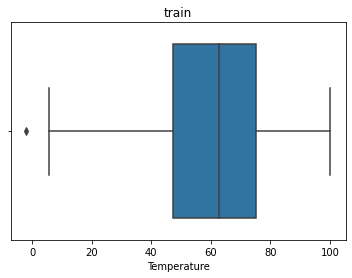

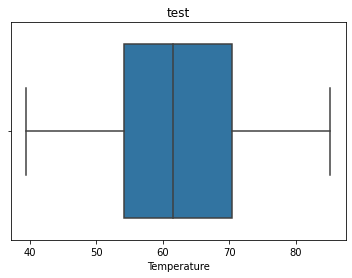

In [12]:
sns.boxplot(x="Temperature", data=train)
plt.title("train")
plt.show()

sns.boxplot(x="Temperature", data=test)
plt.title("test")
plt.show()

### Fuel_Price

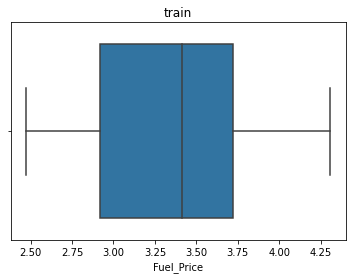

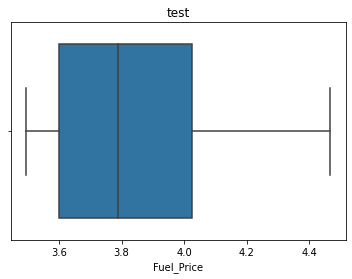

In [13]:
sns.boxplot(x="Fuel_Price", data=train)
plt.title("train")
plt.show()

sns.boxplot(x="Fuel_Price", data=test)
plt.title("test")
plt.show()

### Promotion1~5

In [14]:
train[train["year"]==2012].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1755 entries, 100 to 6254
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1755 non-null   int64         
 1   Store         1755 non-null   object        
 2   Date          1755 non-null   datetime64[ns]
 3   Temperature   1755 non-null   float64       
 4   Fuel_Price    1755 non-null   float64       
 5   Promotion1    1748 non-null   float64       
 6   Promotion2    1299 non-null   float64       
 7   Promotion3    1543 non-null   float64       
 8   Promotion4    1517 non-null   float64       
 9   Promotion5    1755 non-null   float64       
 10  Unemployment  1755 non-null   float64       
 11  IsHoliday     1755 non-null   bool          
 12  Weekly_Sales  1755 non-null   float64       
 13  year          1755 non-null   int64         
 14  month         1755 non-null   int64         
 15  day           1755 non-null   int64 

In [15]:
train = train[train["year"]==2012].reset_index(drop=True)
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
0,101,1,2012-06-01,49.01,3.157,6277.39,21813.16,143.10,1450.13,8483.00,7.348,False,14.254004,2012,6,1,22,2
1,102,1,2012-01-13,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,7.348,False,14.193674,2012,1,13,2,4
2,103,1,2012-01-20,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,7.348,False,14.147970,2012,1,20,3,4
3,104,1,2012-01-27,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,7.348,False,14.092631,2012,1,27,4,4
4,105,1,2012-03-02,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,7.348,False,14.307972,2012,3,2,9,1


In [16]:
train.corr()["Weekly_Sales"]

id             -0.302904
Temperature    -0.064392
Fuel_Price      0.039909
Promotion1      0.413659
Promotion2      0.134196
Promotion3      0.242799
Promotion4      0.225588
Promotion5      0.315160
Unemployment   -0.050877
IsHoliday       0.020721
Weekly_Sales    1.000000
year                 NaN
month           0.026874
day            -0.042233
week            0.023048
season         -0.018757
Name: Weekly_Sales, dtype: float64

In [17]:
promotion_list = ["Promotion1", "Promotion2", "Promotion3", "Promotion4", "Promotion5"]

# for i in promotion_list:

#     sns.histplot(train[i])
#     plt.title(f"train {i} before")
#     plt.show()
    
    # minmax = MinMaxScaler()
    # train[i] = minmax.fit_transform(train[[i]])
    # test[i] = minmax.transform(test[[i]])

    # train[i] = np.log1p(train[i])
    # test[i] = np.log1p(test[i])

    # sns.histplot(train[i])
    # plt.title(f"train {i} after")
    # plt.show()

train.corr()["Weekly_Sales"]

id             -0.302904
Temperature    -0.064392
Fuel_Price      0.039909
Promotion1      0.413659
Promotion2      0.134196
Promotion3      0.242799
Promotion4      0.225588
Promotion5      0.315160
Unemployment   -0.050877
IsHoliday       0.020721
Weekly_Sales    1.000000
year                 NaN
month           0.026874
day            -0.042233
week            0.023048
season         -0.018757
Name: Weekly_Sales, dtype: float64

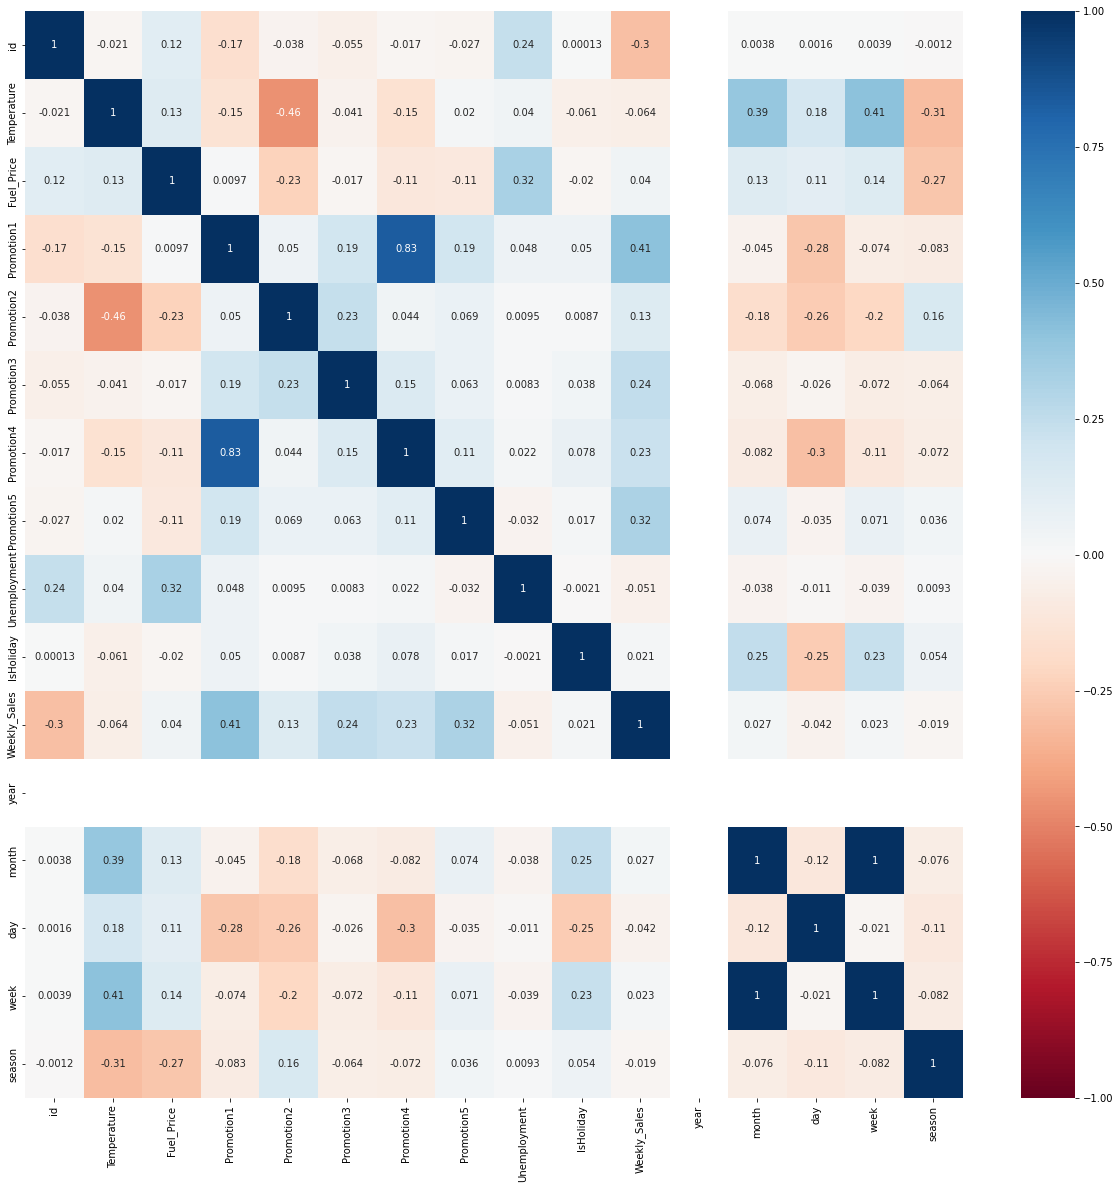

In [18]:
plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

#### Imputation

In [19]:
# for i in train["Store"].unique():

#     train_temp = train[train["Store"]==i]
#     test_temp = test[test["Store"]==i]
#     temp = pd.concat([train_temp, test_temp], axis=0).sort_values("Date").reset_index(drop=True)

#     temp = temp[promotion_list]
    
    # sns.heatmap(temp.isnull())
    # plt.title(f"Store : {i}")
    # plt.show()

    # print(temp.isnull().sum() / len(temp))

In [20]:
total = pd.concat([train, test], axis=0).reset_index(drop=True)

df = pd.DataFrame()
for i in total["Store"].unique():

    temp = total[total["Store"]==i]

    missing_df = temp[promotion_list]
    
    if missing_df.isnull().sum().sum() > 0 :

        # sns.heatmap(missing_df.isnull())
        # plt.title(f"Store : {i}")
        # plt.show()

        imputer = KNNImputer(n_neighbors=5)
        temp[promotion_list]=imputer.fit_transform(missing_df)

    df = pd.concat([df, temp], axis=0)

df.isnull().sum()

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        0
Promotion2        0
Promotion3        0
Promotion4        0
Promotion5        0
Unemployment      0
IsHoliday         0
Weekly_Sales    180
year              0
month             0
day               0
week              0
season            0
dtype: int64

In [21]:
train = df.loc[train.index]
test = df.drop(train.index, axis=0).reset_index(drop=True)
test = test.drop(["Weekly_Sales"], axis=1)

train.isnull().sum()

id              0
Store           0
Date            0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Weekly_Sales    0
year            0
month           0
day             0
week            0
season          0
dtype: int64

### Unemployment

In [22]:
train["Unemployment"].nunique(), test["Unemployment"].nunique()

(90, 30)

### IsHoliday

In [23]:
train["IsHoliday"] = train["IsHoliday"].apply(lambda x : 1 if x==True else 0)
test["IsHoliday"] = test["IsHoliday"].apply(lambda x : 1 if x==True else 0)

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
0,101,1,2012-06-01,49.01,3.157,6277.39,21813.16,143.10,1450.13,8483.00,7.348,0,14.254004,2012,6,1,22,2
1,102,1,2012-01-13,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,7.348,0,14.193674,2012,1,13,2,4
2,103,1,2012-01-20,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,7.348,0,14.147970,2012,1,20,3,4
3,104,1,2012-01-27,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,7.348,0,14.092631,2012,1,27,4,4
4,105,1,2012-03-02,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,7.348,0,14.307972,2012,3,2,9,1


### Feature Extraction

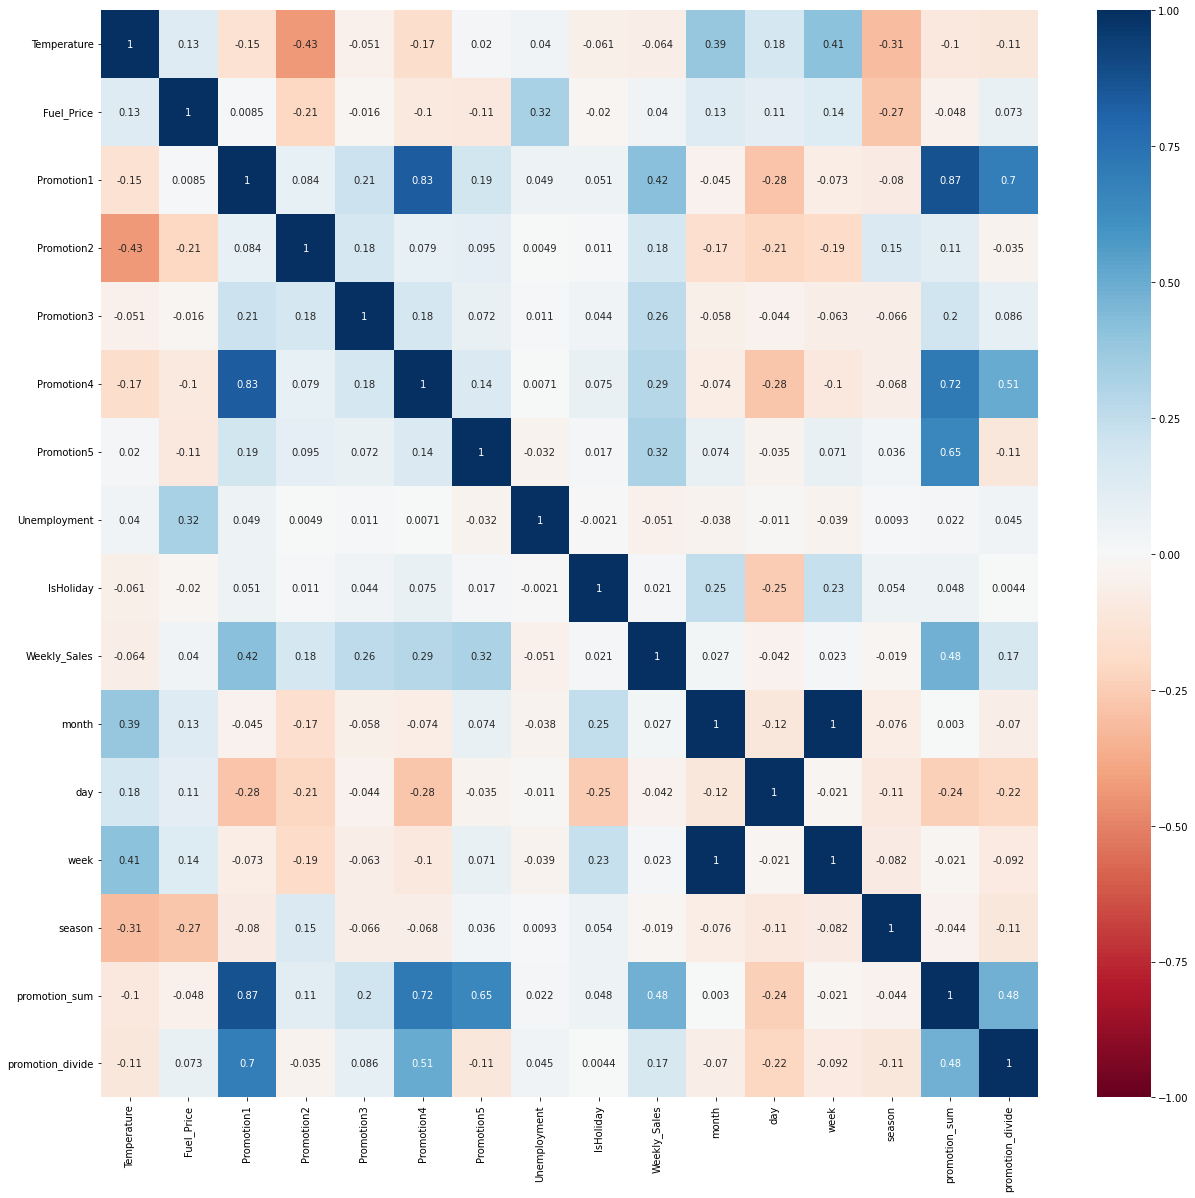

In [24]:
train["promotion_sum"] = train["Promotion1"] + train["Promotion5"]
test["promotion_sum"] = test["Promotion1"] + test["Promotion5"]

train["promotion_divide"] = train["Promotion1"] / train["Promotion5"]
test["promotion_divide"] = test["Promotion1"] / test["Promotion5"]

train = train.drop(["id", "Date", "year"], axis=1)
test = test.drop(["id", "Date", "year"], axis=1)

plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Store             1755 non-null   object 
 1   Temperature       1755 non-null   float64
 2   Fuel_Price        1755 non-null   float64
 3   Promotion1        1755 non-null   float64
 4   Promotion2        1755 non-null   float64
 5   Promotion3        1755 non-null   float64
 6   Promotion4        1755 non-null   float64
 7   Promotion5        1755 non-null   float64
 8   Unemployment      1755 non-null   float64
 9   IsHoliday         1755 non-null   int64  
 10  Weekly_Sales      1755 non-null   float64
 11  month             1755 non-null   int64  
 12  day               1755 non-null   int64  
 13  week              1755 non-null   int64  
 14  season            1755 non-null   int64  
 15  promotion_sum     1755 non-null   float64
 16  promotion_divide  1755 non-null   float64


## Training

In [26]:
estimator1 = LinearRegression(n_jobs=-1)
estimator2 = Ridge(random_state=seed)
estimator3 = Lasso(random_state=seed)
estimator4 = ElasticNet(random_state=seed)
estimator5 = SVR()
estimator6 = KNeighborsRegressor(n_jobs=-1)
estimator7 = DecisionTreeRegressor(random_state=seed)
estimator8 = ExtraTreeRegressor(random_state=seed)
estimator9 = BaggingRegressor(n_jobs=-1, random_state=seed)
estimator10 = ExtraTreesRegressor(n_jobs=-1, random_state=seed)
estimator11 = RandomForestRegressor(n_jobs=-1, random_state=seed)
estimator12 = AdaBoostRegressor(random_state=seed)
estimator13 = GradientBoostingRegressor(random_state=seed)
estimator14 = XGBRegressor(n_jobs=-1, random_state=seed)
estimator15 = LGBMRegressor(n_jobs=-1, random_state=seed)
estimator16 = CatBoostRegressor(verbose=False, random_state=seed)
estimator17 = MLPRegressor(random_state=seed)

### Utils

In [27]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

### Validation - all

In [28]:
X = train.drop(["Weekly_Sales"], axis=1)
y = train["Weekly_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((1316, 59), (439, 59))

In [29]:
%%time

base_ml = [
    estimator1, estimator2, estimator3, estimator4, estimator5, estimator6, estimator7, estimator8, estimator9,
    estimator10, estimator11, estimator12, estimator13, estimator14, estimator15, estimator16, estimator17,
]

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in base_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: total: 16min 6s
Wall time: 1min 51s


((1316, 17), (439, 17))

In [30]:
scores={}
for idx, estimator in enumerate(base_ml):
    scores[idx]=mean_squared_error(np.exp(y_test).round(2),
                                   np.exp(estimator.predict(X_test)).round(2),
                                   squared = True)
sorted(scores.items(), key = lambda item : item[1])

[(0, 7077704958.067097),
 (1, 7289711612.550878),
 (5, 8944652509.056759),
 (9, 13660786866.307676),
 (4, 13953675847.7069),
 (13, 18036251803.153713),
 (15, 18973862562.88641),
 (7, 28269868628.860558),
 (14, 28939954781.323006),
 (10, 36270061508.21295),
 (8, 40464902664.288994),
 (6, 45532791002.69367),
 (12, 50791740307.83576),
 (11, 161208628661.14572),
 (2, 325832538218.56433),
 (3, 325832538218.56433),
 (16, 146704950569081.34)]

In [31]:
model_idx=np.array(sorted(scores.items(), key = lambda item : item[1]))[:top_n_model, 0]
best_ml=[value for i, value in enumerate(base_ml) if i in model_idx]
best_ml

[LinearRegression(n_jobs=-1),
 Ridge(random_state=1011),
 KNeighborsRegressor(n_jobs=-1)]

In [32]:
meta_clf=LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction=meta_clf.predict(meta_ml_X_test)

rmse_all=mean_squared_error(np.exp(y_test).round(2),
                            np.exp(prediction).round(2),
                            squared = True)
print("rmse_all: ", rmse_all)

wandb.log({'RMSE_all': rmse_all})

rmse_all:  5860614972.987979


### Validation - best

In [33]:
%%time

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: total: 8.31 s
Wall time: 1.07 s


((1316, 3), (439, 3))

In [34]:
meta_clf = LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction = meta_clf.predict(meta_ml_X_test)

rmse_best = mean_squared_error(np.exp(y_test).round(2),
                               np.exp(prediction).round(2),
                               squared=True)
print("rmse_best: ", rmse_best)

wandb.log({'RMSE_best': rmse_best})

rmse_best:  6911658880.437508


## Inference

In [35]:
X_train = train.drop(["Weekly_Sales"], axis=1)
y_train = train["Weekly_Sales"]
X_test = test

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((1755, 59), (180, 59))

In [36]:
%%time

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in best_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train.values, X_test, cv)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

CPU times: total: 5.7 s
Wall time: 962 ms


((1755, 3), (180, 3))

In [37]:
meta_clf = LinearRegression()
meta_clf.fit(meta_ml_X_train, y_train)
prediction = meta_clf.predict(meta_ml_X_test)

submission = pd.read_csv("data/sample_submission.csv")
submission["Weekly_Sales"] = np.exp(prediction).round(2)
submission.to_csv("submission.csv", index=False)